## Entregable 2: 
### Calibración de modelo de serie de tiempo para realizar predicción
#### Manolo Ramírez Pintor - A01706155

**Objetivo:** Calibrar un modelo ARIMA-SARIMA para la serie del ÍNDICE GLOBAL DE ACTIVIDAD ECONÓMICA de México ([CLICK AQUÍ: IGAE](https://www.inegi.org.mx/app/indicadores/?t=95&ag=00#D95)).   

Esta serie la puedes descargar del sitio del INEGI. Tienes que realizar el proceso de manejo de datos y calibración del modelo para obtener un pronóstico de la economía mexicana hasta el cierre del sexenio actual (SEP 2024).

Archivo descargado. ✅ ``./datasets/Indicadores20221127001716.xls``

In [1]:
# !pip install xlrd

In [2]:
# !pip install openpyxl

In [3]:
# Importaré las mismas librerías que usé para la parte 1:
import pandas as pd
import numpy as np
import math
# Ignorar warnings de pandas
pd.options.mode.chained_assignment = None  # default='warn'
# Ignorar warnings en general
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter
# Librerias para modelado, regresiones y obtención de resultados:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller # Dickey Fuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Librerías de graficado
import matplotlib.pyplot as plt

Ya que el archivo viene con un formato extraño, decidí modificarlo en Google Docs y pasar los datos normales a una nueva hoja que que le llamé 'data'.

In [4]:
df = pd.read_excel('./datasets/Indicadores20221127001716.xlsx', sheet_name='data')
df

,Indicador,Nombre Indicador,Clave área geográfica,Entidad,Municipio,Periodo,Valor,Excepción,Unidad de medida,Frecuencia,Information Status,Referencias
0,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,2022/09,109.489937,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
1,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,2022/08,113.084930,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
2,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,2022/07,111.112423,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
3,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,2022/06,112.770049,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
4,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,2022/05,114.311084,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
...,...,...,...,...,...,...,...,...,...,...,...,...
352,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,1993/05,63.612900,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
353,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,1993/04,61.865984,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
354,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,1993/03,63.943249,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1
355,6207061409,IGAE. Índice de volumen físico base 2013=100. ...,700,Estados Unidos Mexicanos,Estados Unidos Mexicanos,1993/02,61.022521,NaN,Índice de volumen físico base 2013=100,Mensual,NaN,/a /f1 /r1


Ya que no necesitamos todas las columnas, tomaremos sólo las de Periodo y Valor

In [5]:
df = df.drop(columns=['Indicador', 'Nombre Indicador', 'Clave área geográfica', 
                      'Entidad', 'Municipio', 'Excepción', 'Unidad de medida', 
                      'Frecuencia', 'Information Status', 'Referencias'
                     ])
df

,Periodo,Valor
0,2022/09,109.489937
1,2022/08,113.084930
2,2022/07,111.112423
3,2022/06,112.770049
4,2022/05,114.311084
...,...,...
352,1993/05,63.612900
353,1993/04,61.865984
354,1993/03,63.943249
355,1993/02,61.022521


Ya que las fechas están **severlá**. Las acomodaremos en forma de time-series.

In [6]:
df = df.sort_values('Periodo')
df

,Periodo,Valor
356,1993/01,60.407691
355,1993/02,61.022521
354,1993/03,63.943249
353,1993/04,61.865984
352,1993/05,63.612900
...,...,...
4,2022/05,114.311084
3,2022/06,112.770049
2,2022/07,111.112423
1,2022/08,113.084930


Bueno, ahora acomodaremos los índices porque se quedaron igual.

In [7]:
df = df.reset_index()
df = df.drop(columns=['index'])
df

,Periodo,Valor
0,1993/01,60.407691
1,1993/02,61.022521
2,1993/03,63.943249
3,1993/04,61.865984
4,1993/05,63.612900
...,...,...
352,2022/05,114.311084
353,2022/06,112.770049
354,2022/07,111.112423
355,2022/08,113.084930


Ahora sí, ya podemos trabajar con estos datos.

1. Realizar pruebas estadísticas de estacionariedad y decide el tipo de transformación de la variable.   
    
    Para ello, vamos a revisar y analizar cómo se ve el valor respecto al paso del tiempo.

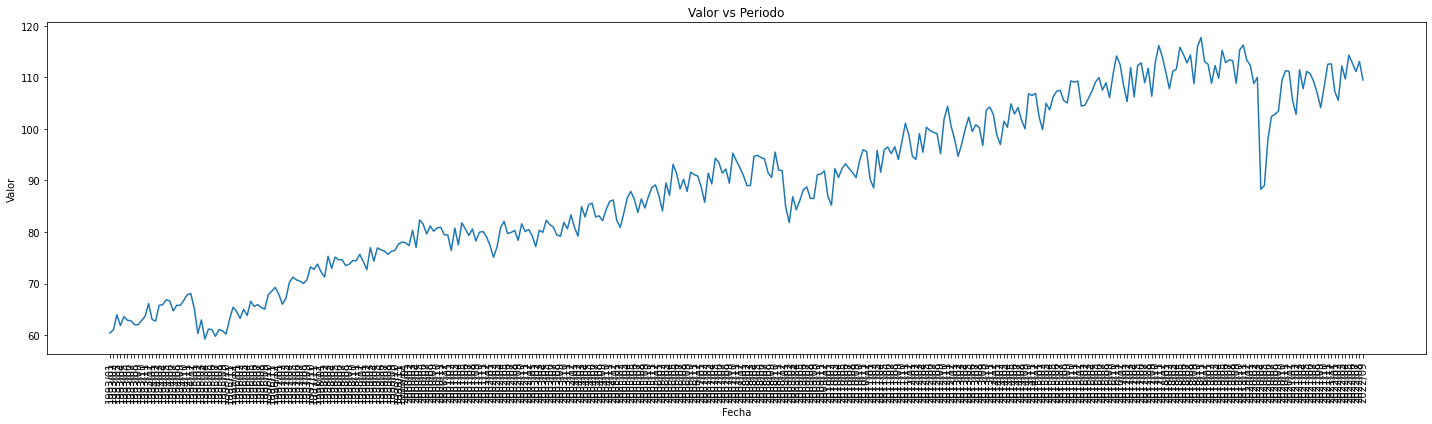

In [8]:
plt.figure(figsize=(20, 6))
plt.plot(df['Periodo'], df['Valor'])
plt.title("Valor vs Periodo")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

A partir de estos datos, podemos observar que a través del tiempo existe un crecimiento constante con ciertas bajadas grandes pero que tienen recuperación, excepto hasta los últimos, ahí hay una bajada extrema y no existe una recuperación completa.   

Esto lo convierte en una tendencia tipo ``no-seasonality`` porque tiende a crecer en el tiempo, además tenemos que ver si hay un patrón dependiendo las estaciones por como se ven los datos en subida y bajada constantes.   

Para probar lo anterior, podemos hacer aplicar una diferencia estacional.

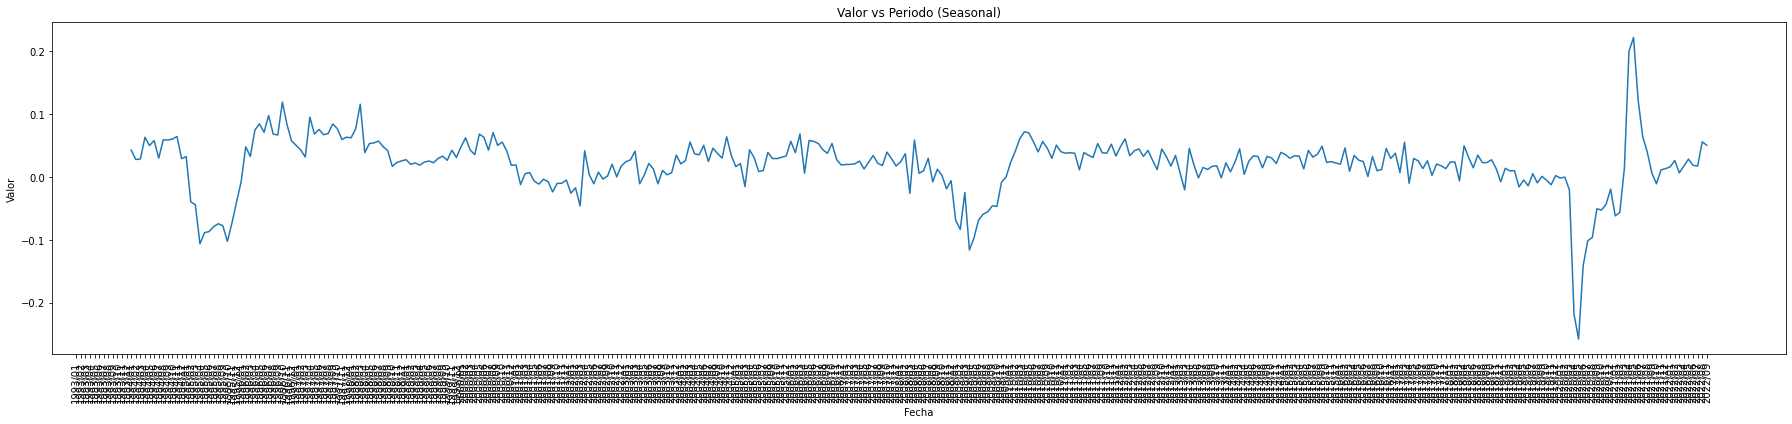

In [9]:
plt.figure(figsize=(25, 6))
plt.title("Valor vs Periodo (Seasonal)")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.xticks(rotation=90)
plt.plot(df['Periodo'], np.log(df['Valor']) - np.log(df['Valor']).shift(12))
plt.tight_layout()
plt.show()

Visualmente podemos apreciar que lo que está ahí parece no ser estacionario, para obtener más información al respecto usaremos ``Augmented Dickey-Fuller Test``.

Primero prepararemos nuestros datos.

In [10]:
df_sns = pd.DataFrame()
df_sns['seasonal'] = np.log(df['Valor'])
df_sns

,seasonal
0,4.101116
1,4.111243
2,4.157996
3,4.124970
4,4.152816
...,...
352,4.738924
353,4.725351
354,4.710543
355,4.728139


In [11]:
val_p = adfuller(df_sns['seasonal'])
val_p

(-1.1552907094223324,
 0.6925269815444512,
 17,
 339,
 {'1%': -3.4497880749874628,
  '5%': -2.870103829170425,
  '10%': -2.571332495975496},
 -1542.4627752324886)

Del array que obtuvimos, podemos observar el valor 0.69 pertenece a nuestro P-Value. Al tener un superior a 0.05 este nos indica que **no se trata de una variable estacionaria** porque tenemos un número superior al indicado.

Para calibrarlo con el modelo ARIMA-SARIMA y teniendo en cuenta el valor, podemos usar los valores ARIMA 0 y SARIMA 1. Es decir, D será 1 y d será de 0. Esto es porque contamos con que NO tenemos una time-series seasonal y la otra es porque debemos calcular el porcentaje de cambio anual.   

Así es como podremos obtener una mejor predicción.

In [12]:
# Haremos un shift time anual para ver qué sucede
df_sns['seasonal'] = np.log(df['Valor']) - np.log(df['Valor']).shift(12)
df_sns = df_sns.dropna()
df_sns = df_sns.reset_index()
df_sns = df_sns.drop(columns=['index'])

# Ahora obtenemos el nuevo P value
val_p2 = adfuller(df_sns['seasonal'])
val_p2

(-3.8809142847110234,
 0.0021798847419226275,
 17,
 327,
 {'1%': -3.45050711373316,
  '5%': -2.8704195794076743,
  '10%': -2.571500856923753},
 -1456.978113477237)

Ahora nuestro P value tiene un valor de 0.002, es mucho menos del 0.05 que se establece como nuestro indicador de si es o no es una variable estacionaria. Quiere decir que con los valores de D 1 y d 0 podremos usar los datos ya de forma estacionaria.

2. Calibra un modelo ARIMA-SARIMA basado en pruebas y gráficos de autocorrelaciones. Explica claramente el proceso de calibración y la razón de cómo va modificando los parámetros.

Para esta parte, lo que haremos es graficar una autocorrelación para encontrar una posible relación de la variable con los valores utilizando lags, en este caso 12.

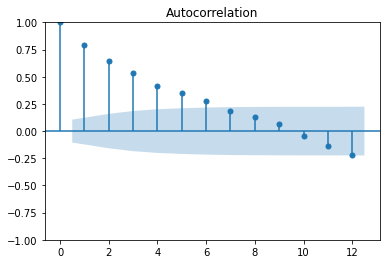

In [13]:
plot_acf(df_sns['seasonal'], lags=12)
plt.show()

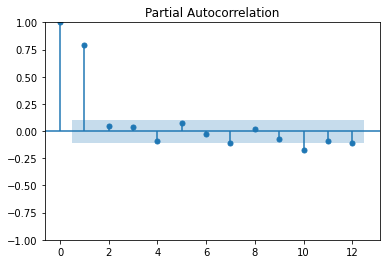

In [14]:
plot_pacf(df_sns['seasonal'], lags=12)
plt.show()

Analizando lo que obtuvimos en las gráficas de autocorrelaciones, se ve una especie de patrón. En el gráfico de correlación podemos ver que hay una tendencia a que los valores bajen. En la autocorrelación parcial podemos ver que los primeros dos lags tienen una alta correlación, las demás son muy bajas.

Para esto, lo mejor será tomar los siguientes valores:   
``p=1``   
``q=0``

**Creando un modelo para SARIMA**
Con los valores que mencionamos anteriormente en base a lo que obtuvimos y que dije que quizá podrían ser lo mejor, armaremos nuestro modelo SARIMA a continuación.

In [15]:
# Definimos d, D, p, P, q y Q
d = 0; D = 1; P = 0; p = 1; q = 0; Q = 0

In [16]:
# Armamos nuestro modelo 
model = sm.tsa.statespace.SARIMAX(
                                df_sns['seasonal'], 
                                order=(p, d, q), 
                                seasonal_order = (P, D, Q, 12), 
                                trend='c',  
                                simple_differencing=True
                                )
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      DS12.seasonal   No. Observations:                  333
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 554.265
Date:                            Mon, 28 Nov 2022   AIC                          -1102.529
Time:                                    01:56:35   BIC                          -1091.105
Sample:                                         0   HQIC                         -1097.974
                                            - 333                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.003     -0.055      0.956      -0.005       0.005
ar.L1          0.7665      0.022     35.231      0.000       0.724       0.809
sigma2         0.0021   5.57e-05     37.582      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              4377.09
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

3. Interpreta los coeficientes y su significancia estadística del modelo calibrado

A partir de lo que obtuvimos con ese modelo, parece ser que el la actividad económica mexicana tiende a ser positiva a pesar de las observaciones que hice al inicio del documento. De hecho tiene una significancia de 76%.

Al extraer los datos del modelo (intercept, ar.L1 y sigma2), podemos ver que queda como...   
``y = -0.0001 + 0.7665 + 0.0021``

Ahora, veremos si el modelo requiere de alguna calibración, así que vamos a checar los residuios. Esto nos va a permitir el conocer si existe white noise, es decir, valores que no representan algún tipo de correlación. 

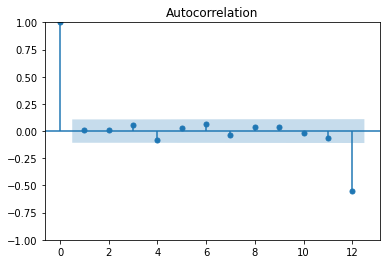

In [17]:
# Creamos un gráfico de Autocorrelación residual
plot_acf(model.fit().resid, lags=12)
plt.show()

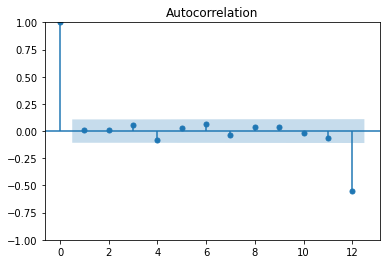

In [18]:
# Creamos un gráfico de Autocorrelación Parcial residual
plot_acf(model.fit().resid, lags=12)
plt.show()

Ahora que tenemos estos dos gráficos nuevos, podemos ver que hay una correlación alta ahora en el LAG 12. Todavía no encontramos algún indicio de que tengamos ruido blanco. Vamos a ver lo que sucede cuando cambiemos nuestro modelo a ver si sale algo.   

Probaré con cambiar el valor de Q de 0 a 1.


In [19]:
# Re-definimos d, D, p, P, q y Q
d = 0; D = 1; P = 0; p = 1; q = 0; Q = 1

In [20]:
# Armamos nuestro modelo 
model2 = sm.tsa.statespace.SARIMAX(
                                df_sns['seasonal'], 
                                order=(p, d, q), 
                                seasonal_order = (P, D, Q, 12), 
                                trend='c',  
                                simple_differencing=True
                                )
model2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        DS12.seasonal   No. Observations:                  333
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 695.510
Date:                              Mon, 28 Nov 2022   AIC                          -1383.019
Time:                                      01:56:38   BIC                          -1367.787
Sample:                                           0   HQIC                         -1376.945
                                              - 333                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.000     -0.769      0.442      -0.001       0.000
ar.L1          0.7688      0.023     33.433      0.000       0.724       0.814
ma.S.L12      -0.9739      0.082    -11.871      0.000      -1.135      -0.813
sigma2         0.0008   7.03e-05     11.550      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              2712.49
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ahora veamos qué es lo que cambió graficando otra vez la autocorrelación y autocorrelación parcial.

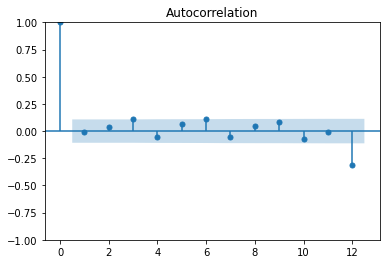

In [21]:
# Creamos un gráfico de Autocorrelación residual
plot_acf(model2.fit().resid, lags=12)
plt.show()

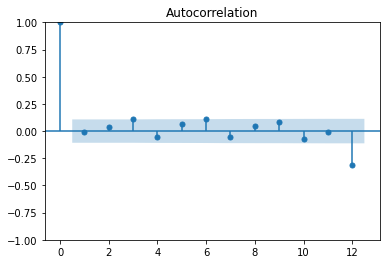

In [22]:
# Creamos un gráfico de Autocorrelación Parcial residual
plot_acf(model2.fit().resid, lags=12)
plt.show()

Ahora podemos observar que nuestro LAG 12 tuvo un decremento, los residuos en general tuvieron mejoras pero parece que todavía podemos continuar mejorando nuestro modelo para realizar una mejor predicción. 

Lo que pienso es que modificando P y q podrían ayudar en hacer que el lag 12 tenga un decremento y que podamos hacer que se conviertan en white noise.

Veamos qué sucede.

In [23]:
# Re-re-definimos d, D, p, P, q y Q
d = 0; D = 1; P = 1; p = 1; q = 1; Q = 1

In [24]:
# Armamos nuestro modelo 
model3 = sm.tsa.statespace.SARIMAX(
                                df_sns['seasonal'], 
                                order=(p, d, q), 
                                seasonal_order = (P, D, Q, 12), 
                                trend='c',  
                                simple_differencing=True
                                )
model3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      DS12.seasonal   No. Observations:                  333
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 708.357
Date:                            Mon, 28 Nov 2022   AIC                          -1404.714
Time:                                    01:56:43   BIC                          -1381.865
Sample:                                         0   HQIC                         -1395.603
                                            - 333                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.000     -0.571      0.568      -0.001       0.000
ar.L1          0.8373      0.036     23.255      0.000       0.767       0.908
ma.L1         -0.0975      0.051     -1.923      0.054      -0.197       0.002
ar.S.L12      -0.2187      0.047     -4.676      0.000      -0.310      -0.127
ma.S.L12      -0.9170      0.066    -13.998      0.000      -1.045      -0.789
sigma2         0.0008   3.49e-05     21.900      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              2554.29
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ahora veamos qué es lo que cambió graficando otra vez la autocorrelación y autocorrelación parcial.

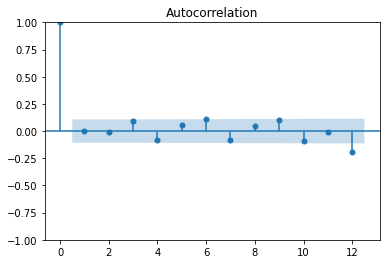

In [25]:
# Creamos un gráfico de Autocorrelación residual
plot_acf(model3.fit().resid, lags=12)
plt.show()

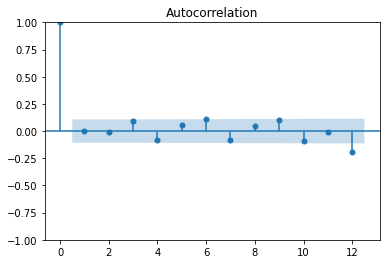

In [26]:
# Creamos un gráfico de Autocorrelación Parcial residual
plot_acf(model3.fit().resid, lags=12)
plt.show()

Ahora, visualmente podemos observar que los LAGS ya son más lo que estábamos buscando a ese ruido blanco, también podemos apreciar que el LAG 12 está más acercado a 0 con los demás y el primero se mantiene igual.   

Ahora pasemos con la verdera **interpretación de coeficientes**:   

En nuestra actividad económica mexicana, podemos observar que el índice global es positivo. Eso no cambió desde el primer modelo generado.   

De acuerdo a la información del summary del último modelo que tomamos hay varias cosas que sí cambiaron, por ejemplo, podemos ver que el LAG 1 representa 83.73% de crecimiento. Antes era de 76%.   

Por otro lado podemos ver que el -21.87% perteneciente a dos meses atrás, va hacia el crecimiento anual. Antes este era de -97%.

En general esto representan relaciones positivas y más significancia, pues el P value sigue siendo menor al margen de 0.05. (0.045)   

En el lag 12 podemos observar que todavía está presenta una magnitud negativa, pero es mejor que antes. Su p value también es menor a 0.05. (0.000)   

Con todo esto en cuenta, se ha relizado lo posible para tener lo más que se puede de ruido blanco en los datos, con este modelo ahora realizaremos las predicciones hasta septiembre del 2024.

4. Realiza una predicción de la variable utilizando el modelo calibrado.

In [27]:
# Agarramos el modelo que ya teníamos y generamos las predicciones
model_fit = model3.fit()
prediction = np.asarray((model_fit.forecast(steps=24)))

Al final hasta aquí alcancé a terminar. :(   